# xbgoost_shap

In [239]:
# Loading package
import os
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu

In [41]:
os.chdir(r'/Volumes/电子老祖/现在正在写的论文/帕金森meta分析/分肠型/重新/Euro/ET-L')

In [42]:
data_raw=pd.read_table('data.txt')

In [43]:
def xgb_class(data_train, target_train, data_test, target_test):
    from scipy.stats import uniform
    from xgboost import XGBClassifier
    from sklearn.model_selection import RandomizedSearchCV
    import numpy as np # Added import for np.linspace

    XGB = XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric=['logloss', 'auc', 'error'])
    # from scipy.stats import reciprocal # This import is not used, can be removed
    param_dist = {
        "learning_rate": np.linspace(0.01, 2, 20),
        "subsample": np.linspace(0.7, 0.9, 20),
        'colsample_bytree': np.linspace(0.5, 0.98, 10),
        'n_estimators': range(500, 2000, 20),
        'max_depth': range(10, 200),
    }
    # n_iter=300, train 300 times, the larger the value, the higher the parameter accuracy, but the longer the search time
    # n_jobs = -1, use all CPUs for training, default is 1, use 1 CPU
    # cv is the number of cross-validation folds
    grid = RandomizedSearchCV(XGB, param_dist, cv=3, n_iter=300, n_jobs=-1)
    grid.fit(data_train, target_train)
    # Return the best estimator
    best_estimator = grid.best_estimator_
    # Cross-validation
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(best_estimator, data_train, target_train, cv=10, n_jobs=-1)
    # Accuracy
    from sklearn.metrics import accuracy_score
    y_pred = best_estimator.predict(data_test)
    acc_value = accuracy_score(target_test, y_pred)
    return best_estimator, scores, acc_value, y_pred

In [44]:
#Convert to np.array matrix
data_full=data_raw.iloc[:,2:].astype(float)
target_full=np.array(data_raw.iloc[:,1].astype(int))

In [45]:
#Split data
from sklearn.model_selection import train_test_split
data_train,data_test,target_train,target_test = train_test_split(data_full,target_full,test_size=0.2) #test size = 10%

In [283]:
#Feature screening through statistical analysis
# Mann-Whitney U test function
def perform_mannwhitneyu_test(group1, group2):
    stat, p = mannwhitneyu(group1, group2)
    return p

p_value=[]
for i in range(data_train.shape[1]):
    group1=data_train.iloc[target_train==0,i]
    group2=data_train.iloc[target_train==1,i]
    p_value.append(perform_mannwhitneyu_test(group1, group2))

data_train=data_train.loc[:,np.array(p_value)<0.05]
data_test=data_test.loc[:,np.array(p_value)<0.05]

In [284]:
xgb_model,xgb_kfold,xgb_acc,xgb_pred=xgb_class(data_train,target_train,data_test,target_test)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


In [285]:
print('10-fold crossover:%s'%list(xgb_kfold))
print('average:%s±%s'%(round(xgb_kfold.mean(),2),round(xgb_kfold.std()/3.16,2)))
print('test set:',xgb_acc,'%')

10-fold crossover:[0.7068965517241379, 0.7413793103448276, 0.6379310344827587, 0.7413793103448276, 0.7586206896551724, 0.6896551724137931, 0.6724137931034483, 0.7758620689655172, 0.8275862068965517, 0.7758620689655172]
average:0.73±0.02
test set: 0.7328767123287672 %


In [286]:
importance=pd.concat([pd.DataFrame(data_full.columns),pd.DataFrame(xgb_model.feature_importances_)],axis=1,ignore_index=True)
importance.to_csv('importance.csv',header=None,index=None)

In [287]:
#sklearn save model
import joblib
joblib.dump(xgb_model,'xgboost분류.pkl')

['xgboost분류.pkl']

In [288]:
#保存数据
pd.DataFrame(data_train).to_csv('data_train.csv',index=True,header=True)
pd.DataFrame(data_test).to_csv('data_test.csv',index=True,header=True)
pd.DataFrame(target_train).to_csv('target_train.csv',index=None,header=None)
pd.DataFrame(target_test).to_csv('target_test.csv',index=None,header=None)

In [289]:
#ROC graph
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc

In [290]:
target_probabilities=xgb_model.predict_proba(data_test)[:,1]

In [291]:
false_positive_rate,true_positive_rate,threshold=roc_curve(target_test,target_probabilities)

In [292]:
auc = auc(false_positive_rate, true_positive_rate)
print('AUC的值为:%s'%auc)

AUC的值为:0.8027823240589198


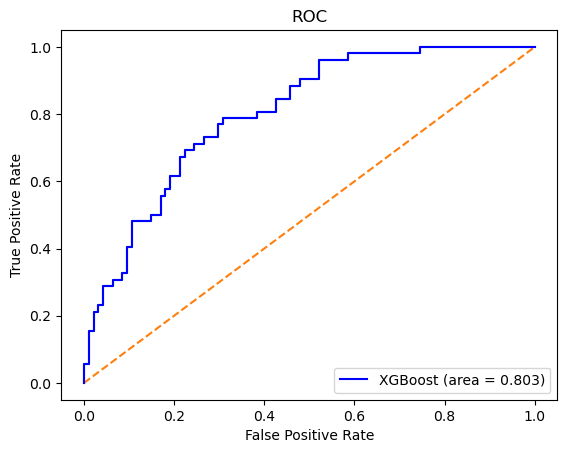

In [293]:
plt.title('ROC')
plt.plot(false_positive_rate,true_positive_rate)
plt.plot([0,1],ls='--')
#plt.plot([0,0],[1,0],c='.7'),plt.plot([1,1],c='.7')
plt.plot(false_positive_rate, true_positive_rate, label='XGBoost (area = {:.3f})'.format(auc),color='blue')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.savefig('roc.png',dpi=600,bbox_inches = 'tight')

In [294]:
def interval(model,test_x,test_y,target='Accuracy',interval_num=0.95):
    '''Insert desired indicators in target= Example: AUC, Accuracy, Sensitivity, Specificity, Precision, F1'''
    from scipy import stats
    from sklearn.metrics import roc_curve,roc_auc_score
    from sklearn.metrics import auc
    from sklearn.metrics import confusion_matrix
    y_pred=model.predict(test_x)
    y_pred_proba=model.predict_proba(test_x)[:,1]
    n_bootstraps = 1000
    rng_seed = 42  # control reproducibility
    bootstrapped_scores = []
    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(test_y[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue
        TN, FP, FN, TP = confusion_matrix(test_y[indices], y_pred[indices]).ravel()
        Accuracy = (TP+TN)/(TP+FP+FN+TN)
        Sensitivity = TP/(TP+FN)
        Specificity = TN/(TN+FP)
        Precision = TP/(TP+FP)
        F1 = 2*(Sensitivity * Precision) / (Sensitivity + Precision)
        AUC = roc_auc_score(test_y[indices], y_pred_proba[indices])
        bootstrapped_scores.append(locals()[target])
    socres=np.array(bootstrapped_scores)
    mean=socres.mean()
    std=socres.std()/np.sqrt(len(socres))
    interval=stats.norm.interval(interval_num,mean,std)
    interval_num*100
    print('%s값:'%target,mean)
    print('%s Starndard Error:'%target,std)
    print('%s'%(int(interval_num*100)),'%신뢰 구간:',interval)
    return [mean,std,interval]

In [295]:
#target= Enter the indicator you want to see. Example: AUC, Accuracy, Sensitivity, Specificity, Precision, F1
target=['AUC','Accuracy','Sensitivity','Specificity','Precision','F1']
result=[]
for i in target:
    result.append([i]+interval(xgb_model,data_test,target_test,target=i,interval_num=0.95))
result=pd.DataFrame(result)
result.columns=['target','mean','std','interval']

AUC값: 0.8029567676097382
AUC Starndard Error: 0.0011267410002242415
95 %신뢰 구간: (0.800748395829394, 0.8051651393900824)
Accuracy값: 0.7328972602739725
Accuracy Starndard Error: 0.0011839015041915212
95 %신뢰 구간: (0.7305768559645144, 0.7352176645834306)
Sensitivity값: 0.5779343688078942
Sensitivity Starndard Error: 0.0022509714498148044
95 %신뢰 구간: (0.5735225458360292, 0.5823461917797591)
Specificity값: 0.8181655749561865
Specificity Starndard Error: 0.001288309909076426
95 %신뢰 구간: (0.8156405339334706, 0.8206906159789024)
Precision값: 0.6367612022677438
Precision Starndard Error: 0.0022004162386459413
95 %신뢰 구간: (0.6324484656890007, 0.6410739388464869)
F1값: 0.6034102108179168
F1 Starndard Error: 0.0018751682311530665
95 %신뢰 구간: (0.5997349486199031, 0.6070854730159305)


In [296]:
result

,target,mean,std,interval
0,AUC,0.802957,0.001127,"(0.800748395829394, 0.8051651393900824)"
1,Accuracy,0.732897,0.001184,"(0.7305768559645144, 0.7352176645834306)"
2,Sensitivity,0.577934,0.002251,"(0.5735225458360292, 0.5823461917797591)"
3,Specificity,0.818166,0.001288,"(0.8156405339334706, 0.8206906159789024)"
4,Precision,0.636761,0.002200,"(0.6324484656890007, 0.6410739388464869)"
5,F1,0.603410,0.001875,"(0.5997349486199031, 0.6070854730159305)"


In [297]:
#shap

In [1]:
import shap
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
shap.initjs() # In the notebook environment, load the JS code for visualization

In [2]:
os.chdir('/Volumes/电子本体/现在正在写的论文/帕金森meta分析/分肠型/Eur/ET-L/机器学习')

In [9]:
data_train=pd.read_csv('data_train.csv',index_col=0)
data_test=pd.read_csv('data_test.csv',index_col=0)
target_train=np.array(pd.read_csv('target_train.csv',header=None)[0])
target_test=np.array(pd.read_csv('target_test.csv',header=None)[0])

# Load the model
import joblib
xgb_model=joblib.load('xgboost분류.pkl')

In [10]:
#Calculate SHAP value
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(data_train,check_additivity=False)# 传入特征矩阵X，计算SHAP值

[16:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


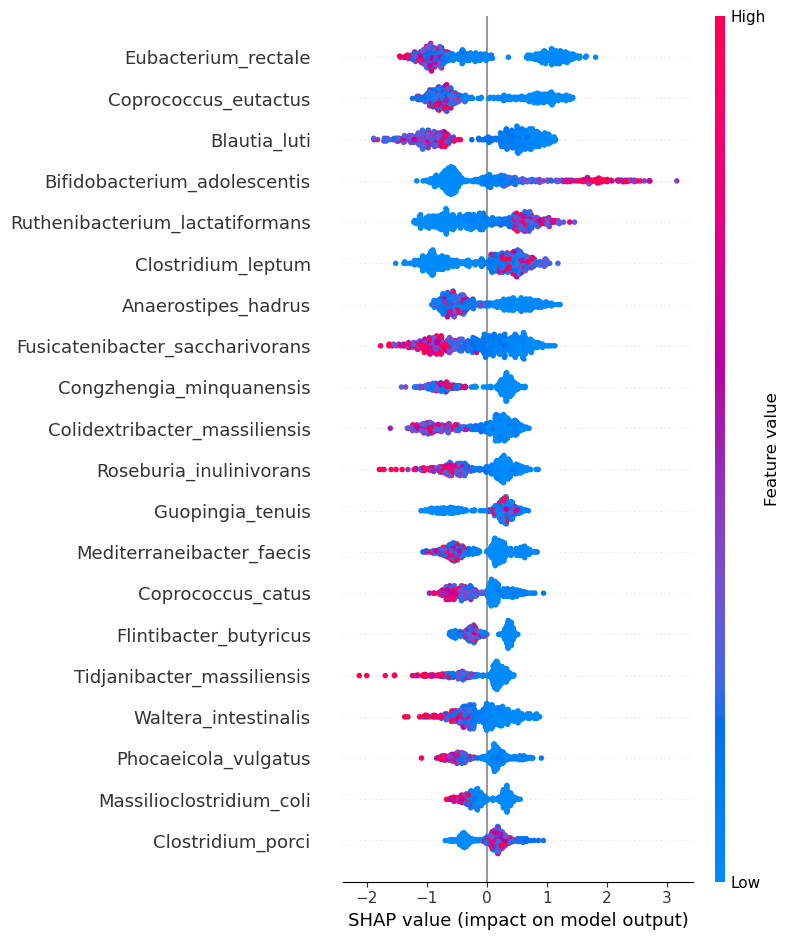

In [11]:
#summarize the effects of all the features
fig=shap.summary_plot(shap_values, data_train,show=False,max_display=20)
plt.savefig('shap_1.png',dpi=600,bbox_inches = 'tight')

In [12]:
#Importance calculation
sv1=pd.DataFrame(shap_values)
sv1=sv1.apply(lambda x: abs(x))
sv1=pd.DataFrame(sv1.apply(np.mean))
sv1.insert(loc=0,column='name',value=data_train.columns)
sv1.to_csv('shap_importance-total_1.csv',header=None,index=None)